Up-to-date version: https://colab.research.google.com/drive/1d7Wc8WVzv62djb9W3k3aLFyyeCA90c9_

## Entropy
Shannon entropy is defined as the logarithm of "the number of states" $1/p(x)$, averaged by probability $p(x)$:
$$ H = \sum_{x} p(x) \log_2 {1 \over p(x)} \tag{1}$$
"The number of states" $1/p$ is actually how many times, on average, you have to flip a bent coin with the probability of heads $p$ to get the first head. I call it "the number of states" to indicate the relationship with the Boltzmann entropy $\ln W$, where $W$ counts the number of ways the atoms or molecules of gases can be arranged. This relationship was pointed out by Shannon and I find it useful.

Another way of writing formula $(1)$ is
$$ H =- \sum_{x} p(x) \log_2 p(x) \tag{2}$$



The logarithm is taken with a base of 2 to measure how many bits (0's or 1's) you need to represent an event $x$ that comes from the distribution $p(x)$.

In the simplest case, when a random variable $x$ has two outcomes like flipping a coin with the probability of heads $p$, the entropy equals
$$ H_2(p) = p \log_2 {1 \over p} + (1-p) \log_2 {1 \over 1-p} \tag{3}$$

Subscript $H_2$ indicates the are only two outcomes. And here is the plot.

In [0]:
!pip install numpy==1.15.4 matplotlib==3.0.1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


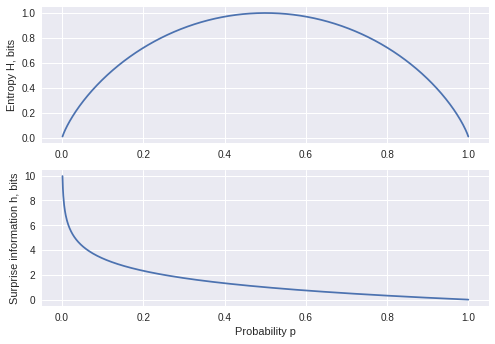

In [0]:
import numpy as np
import matplotlib.pyplot as plt

proba = np.linspace(start=0, stop=1, num=1000)

plt.subplot(211)
entropy = proba * np.log2(1/proba) + (1-proba) * np.log2(1/(1-proba))
plt.plot(proba, entropy)
plt.ylabel("Entropy H, bits")

plt.subplot(212)
surprise_information = np.log2(1/proba)
plt.plot(proba, surprise_information)
plt.xlabel("Probability p")
plt.ylabel("Surprise information h, bits")
plt.show()

`RuntimeWarning: divide by zero encountered ...` warns about two corner cases when $p=0$ and $p=1$. You can prove that $\lim_{p\to 0} p \log p = 0$.


 ### Discrete entropy example

Find the entropy of a random variable $X$ that comes from a discrete uniform distribution.

Let's start simple. What's the entropy of a discrete random variable $X$ in a sequence of

* $[5, 5, 8]$
* $[7681, 7681, -23]$
* $[cat,\ cat,\ dog]$

In [0]:
from collections import defaultdict
from tqdm import tqdm


def discrete_entropy(digits) -> float:
    """
    :param digits: realizations of a discrete random variable X
    :return estimated entropy of X in bits
    """
    # your code goes here
    unique, counts = np.unique(digits, return_counts=True)
    proba = counts / len(digits)
    entropy = sum(proba * np.log2(1/proba))
    return entropy

experiment1 = [5, 5, 8]
print(f"Entropy of {experiment1} is {discrete_entropy(experiment1):.3f} bits.")

Entropy of [5, 5, 8] is 0.918 bits.


Calculating entropy: 100%|██████████| 9/9 [00:00<00:00, 69.12it/s]


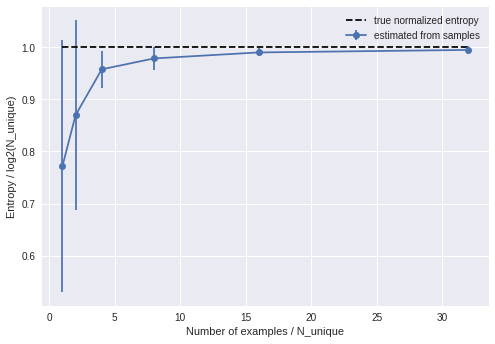

In [0]:
def test_discrete_entropy():
    sizes_normalized = np.power(2, np.arange(6, dtype=int))
    entropy_normalized = defaultdict(list)
    for n_unique_digits in tqdm(np.power(2, np.arange(start=1, stop=10, dtype=int)), desc="Calculating entropy"):
        entropy_true = np.log2(n_unique_digits)
        for size in sizes_normalized:
            for trial in range(20):
                xs = np.random.randint(low=0, high=n_unique_digits, size=size*n_unique_digits)
                entropy = discrete_entropy(xs)
                entropy_normalized[size].append(entropy / entropy_true)
    entropy_mean = [np.mean(entropy_normalized[s]) for s in sizes_normalized]
    entropy_std = [np.std(entropy_normalized[s]) for s in sizes_normalized]
    plt.errorbar(x=sizes_normalized, y=entropy_mean, yerr=entropy_std, fmt='o-', label='estimated from samples')
    plt.xlabel('Number of examples / N_unique')
    plt.ylabel('Entropy / log2(N_unique)')
    plt.hlines(y=1, xmin=min(sizes_normalized), xmax=max(sizes_normalized), linestyles='dashed', label='true normalized entropy')
    plt.legend()
    plt.show()


test_discrete_entropy()

### Entropy-based binning. Decision tree.

#### O-Ring failure analysis

You have a physical system (O-Ring) that breaks at a certain temperature $T_{critical}$. For a given range of temperatures $[T_{min}, T_{max}]$, you heated the O-Rring and wrote down

    1) temperature
    2) material it's made of (`soft` or `rigid`) 
    3) whether the ring failed (`Y`) or not (`N`).

![](https://www.easternseals.co.uk/wp-content/uploads/2015/04/epdm-o-ring.jpg)

And you want to cluster your data. Let $T_{critical}=60$ and we assume that material has nothing to do with the ring failure (you didn't know that beforehead). One way to deal with the categorical data is by building a decision tree.

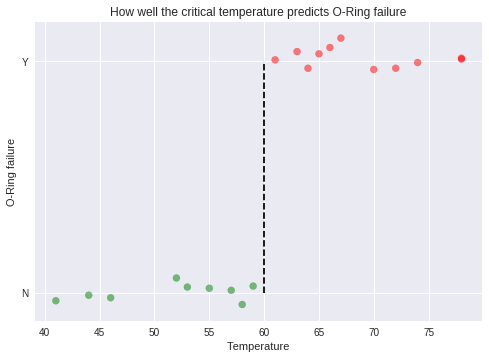

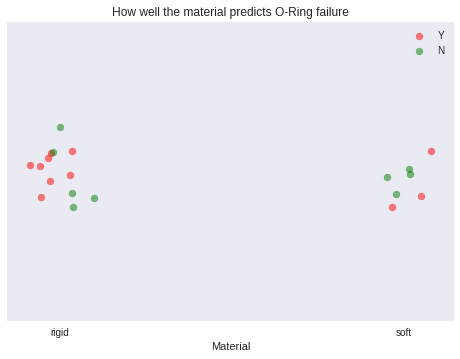

In [0]:
np.random.seed(26)

T_CRITICAL = 60
N_SAMPLES = 20

temperatures = np.random.randint(low=40, high=80, size=N_SAMPLES)
failures = np.where(temperatures > T_CRITICAL, 'Y', 'N')
materials = np.where(np.random.rand(N_SAMPLES) > 0.5, 'rigid', 'soft')


def jitter(data, amount=0.02):
    labels, data_noisy = np.unique(data, return_inverse=True)
    data_noisy = data_noisy + amount * np.random.randn(len(data))
    return labels, data_noisy


def visualize_temperature():
    failure_labels, failures_noisy = jitter(failures, amount=0.05)
    colors = np.where(failures == 'Y', 'red', 'green')
    plt.scatter(temperatures, failures_noisy, c=colors, alpha=0.5)
    plt.vlines(x=T_CRITICAL, ymin=0, ymax=1, linestyles='dashed')
    plt.yticks([0, 1], failure_labels)
    plt.xlabel('Temperature')
    plt.ylabel('O-Ring failure')
    plt.title('How well the critical temperature predicts O-Ring failure')
    plt.show()


def visualize_material():
    material_types, materials_noisy = jitter(materials, amount=0.05)
    materials_failed = materials_noisy[failures == 'Y']
    materials_not_failed = materials_noisy[failures == 'N']
    plt.scatter(materials_failed, np.random.randn(len(materials_failed)), c='red', alpha=0.5, label='Y')
    plt.scatter(materials_not_failed, np.random.randn(len(materials_not_failed)), c='green', alpha=0.5, label='N')
    plt.yticks([-7, 7], [])
    plt.xticks(range(len(material_types)), material_types)
    plt.xlabel('Material')
    plt.legend()
    plt.title('How well the material predicts O-Ring failure')
    plt.grid(False)
    plt.show()


visualize_temperature()
visualize_material()

You have two options: split the data by the critical temperature first and then, if necessary, split the remainder by the material or change the order:

![](https://i.imgur.com/Q2EEL0N.png)

If you split the data by the material and then by the temperature, you'll be asking two questions per new sample, while in fact, only one question suffices - is $T>T_{critical}$?

In our simple example the optimal split is defined by the temperature only. But real data with many parameters might contain highly correlated explanatory variables. Besides making correct predictions, we want to ask our classifier as few YES-or-NO questions as possible. Of course, we can do an exhaustive search in the parameter space. But we'd like to build the decision tree with _no backtracking_. The criterion is simple: we should always split the data by the most _informative_ explanatory variable first.

From the diagram above,

\begin{equation*}
p(Failure=Y|Temperature)=
\begin{cases}
  1, \ T>T_{critical} \\      
  0, \ T \le T_{critical}
\end{cases}
\end{equation*}

\begin{equation*}
p(Failure=Y|Material)=
\begin{cases}
  {8 \over 13}, \ \text {rigid} \\      
  {3 \over 7}, \ \text {soft} 
\end{cases}
\end{equation*}

$p(Failure=Y|Temperature)$ is much highly peaked than $p(Failure=Y|Material)$. Our strategy is to pick the '$?$' among all explanatory variables such that the likelihood $p(Failure=Y|?)$ is highly peaked. While Fisher information measures the distribution peakedness in a local point, the conditional entropy $H(Failure|?)$ gives a scalar, that indicates how much entropy (variation) is left when an event '$?$' has been observed. Low $H(Failure|?)$ indicates highly peaked likelihood function $p(Failure|?)$.

Conditional entropy $H(Failure|X)$ is defined similar to equation $(1)$:

$$ H(Failure|X) = \sum_{x} p(X=x) H(Failure|X=x) \\ =\sum_{x} p(X=x)\sum_{f\in\{Y,N\}}p(Failure=f|X=x) \cdot \log_2 {1 \over p(Failure=f|X=x)}  \tag{4}$$


Substituting $X$ for temperature and material,

$$ H(Failure|T>T_{critical}) = p(T \le 60) \cdot H_2(p(Y)=0) + p(T>60) \cdot H_2(p(Y)=1) \\ = {9 \over 20} \cdot 0 + {11 \over 20} \cdot 0 = 0 $$

$$ H(Failure|Material) = p(\text{rigid}) \cdot H_2(p(Y)={8 \over 13}) + p(\text{soft}) \cdot H_2(p(Y)={3 \over 7}) \\ = {13 \over 20} \cdot 0.961 + {7 \over 20} \cdot 0.985 = 0.970 $$

Entropy of $H(Failure|T>T_{critical})$ is zero, meaning there is no variation left once the temperature is observed and no further questions are needed to split the remained data. Entropy of $H(Failure|Material)$ is $0.970$, meaning that besides asking one question "What is the material?", on average, we need to ask $0.970$ more questions to correctly predict the ring failure. One nice thing about entropy is that it turns the model accuracy into the minimum number of questions you need to ask on average to gain the given model accuracy.

When the critical temperature is not known, you can find it by minimizing $T_{critical}=\text{argmin } H(Failure|T>T_{critical})$. You can verify that this approach gives the same optimal value $T_{critical}=60$ as a naive error counting.


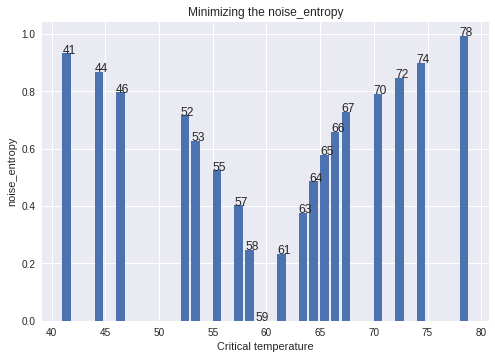

In [0]:
def noise_entropy(t_critical):
    """
    Conditional entropy is sometimes called the 'noise entropy' that quantifies 
    the variability of the observed data (ring failures), given the temperature.

    :param t_critical: critical temperature
    :return: noise entropy H(Failure|Temperature)
    """
    cold = temperatures <= t_critical
    hot = ~cold
    entropy_cold = discrete_entropy(failures[cold]) * np.mean(cold)
    entropy_hot = discrete_entropy(failures[hot]) * np.mean(hot)
    return entropy_cold + entropy_hot


def incorrect_predictions(t_critical):
    """
    A naive approach is to count how many times we make incorrect predictions 
    about our assumption that T > T_critical explains the data perfectly.
    This objective function gives the same optimum as noise_entropy().

    :param t_critical: critical temperature
    :return: number of incorrect predictions
    """
    cold = temperatures <= t_critical
    hot = ~cold
    error_cold_fails = np.sum(failures[cold] != 'Y') + np.sum(failures[hot] != 'N')
    error_hot_fails = np.sum(failures[cold] != 'N') + np.sum(failures[hot] != 'Y')
    error = min(error_cold_fails, error_hot_fails)
    return error


def minimize_objective_function(objective_function=noise_entropy):
    """
    :param objective_function: objective function that we want to minimize 
    """
    errors = []
    temperatures_unique = np.unique(temperatures)

    for t_critical in temperatures_unique:
        loss = objective_function(t_critical)
        errors.append(loss)

    plt.bar(temperatures_unique, errors, align='edge')
    plt.xlabel('Critical temperature')
    plt.ylabel(objective_function.__name__)
    plt.title(f'Minimizing the {objective_function.__name__}')
    for temperature, entropy_bar in zip(temperatures_unique, errors):
        plt.text(temperature, entropy_bar, str(temperature))
    plt.show()


minimize_objective_function(objective_function=noise_entropy)

The described entropy-based binning algorithm (bin the data in hot $T>T_{critical}$ and cold $T \le T_{critical}$ clusters or by material) is called _maximum information gain_ because the entropy of the ring failure $H(Failure)$ is a constant 

<TABLE>
<TR><TH colspan="2">O-Ring Failure
<TR><TH>Y<TH>N
<TR><TD>11<TD>9
</TABLE>

$$H(Failure)=H_2(p(Y)={11 \over 20})=0.993$$ 

and what we can do is just minimizing the conditional entropy $H(Failure|?)$. By doing so, we maximize the information gain between the ring failure and the chosen explanatory variable. The information gain (or _mutual information_) is defined then as

$$I(Failure; T>T_{critical}) = H(Failure) - H(Failure|T>T_{critical}) = 0.993 - 0 = 0.993 \text{ bits}$$
$$I(Failure; Material) = H(Failure) - H(Failure|Material) = 0.993 - 0.970 = 0.023 \text{ bits}$$

In such a perspective, the material stores almost none information about the ring failure, as it should not surprise you, because the material values were generated randomly (independently of the ring failure).